### Detecção de valores anômalos

Os valores anômalos são objetos dentro de um conjunto de dados que expressam um comportamento desviante dos demais e podem resultar de falhas no registro, digitação, aferição instrumental configuram como outliers dentro de uma região adensada de dados. Este algoritmo trabalha com a detecção dos valores anômalos por meio de Local Outlier Factor (LOF) e Isolation Forest para evitar que prejudique a generalização dos modelos de aprendizado de máquina que estão usando esse dataframe.

In [68]:
#Importação das bibliotecas
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#criando o DataFrame "df_chem"
df = pd.read_csv("Minerals_Database3.csv")  # Importação do dataset para ser utilizado como dataframe
# Remoção de colunas não necessárias para o dataframe

df = df.drop(['A'], axis=1)
df = df.drop(['Name'], axis=1)

dados_cat = df.reindex(df.columns[[0,2,4]], axis = 1) # Remoção de dados categóricos
dados_categoricos = dados_cat.astype("category") # Tratamento de dados para o tipo categórico
newlist = [x for x in range(7,135)] # Range para pegarmos dados que estão em porcentagem
porcent_df = df.reindex(df.columns[newlist], axis = 1) # Coleta dos dados de elementos em porcentagem
df_chem = df.reindex(df.columns[[1,3,5,135,136,137]], axis=1) # Reindexação de um dataframe contendo apenas propriedades fisico-químicas
df_chem, dados_categoricos

df_remove=df_chem.loc[(df["Refractive Index"] == 0.000)]

df_chem = df_chem.drop(df_remove.index)
print(df_chem)

     Mohs Hardness  Specific Gravity  Refractive Index  Molar Mass  \
0             4.50             3.240             1.580  817.339002   
1             2.75             3.446             1.592  435.069330   
2             2.00             4.420             2.085  921.092220   
4             5.50             1.050             1.634  861.185368   
5             3.50             3.295             1.457  225.618151   
..             ...               ...               ...         ...   
803           7.50             4.650             1.928  526.041800   
805           6.50             3.230             1.702  379.378178   
806           3.50             2.180             1.590  492.887716   
807           7.00             3.411             1.596  263.580584   
808           0.00             3.146             1.633  576.801907   

     Molar Volume  Calculated Density  
0        0.123390               5.498  
1        0.056083               6.439  
2        0.122631               6.234  

In [69]:
#Determina o tamanho do teste, o ponto de início do algoritmo, os atributos e o dataframe utilizado

TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 300
FEATURES = ["Specific Gravity", "Mohs Hardness", 'Molar Mass', 'Molar Volume', 'Calculated Density']

df = df_chem
X = df.reindex(FEATURES, axis=1)

In [70]:
#Normaliza os dados, pois o algoritmo se baseia em distâncias

normalizador = MinMaxScaler()
normalizador.fit(X)
X_norm = normalizador.transform(X)

In [71]:
#Análise dos componentes principais

pca = PCA()
pca.fit(X_norm)
X_pca = pca.transform(X_norm)

#### Local Outlier Factor (LOF)

É um algoritmo usado para encontrar pontos de dados anômalos, medindo o desvio local de um determinado ponto de dados em relação aos seus vizinhos. É baseado no conceito de densidade local, onde a localidade é dada por k vizinhos mais próximos, cuja distância é utilizada para estimar a densidade. Ao comparar a densidade local de um objeto com as densidades locais de seus vizinhos, pode-se identificar regiões de densidade semelhante e pontos que possuem densidade substancialmente menor que seus vizinhos, considerados outliers.

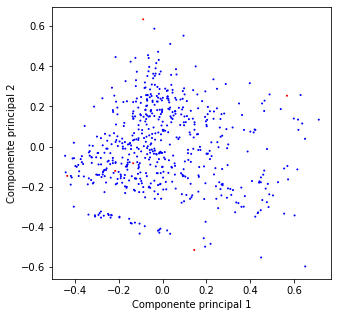

In [72]:
# Indica a fração de outlier que será detectada no conjunto de dados
FRACAO_OUTLIERS = 0.01

# Indica o número de vizinhos que serão considerados
N_VIZINHOS = 35

CORES = np.array(["red", "blue"])

modelo_lof = LocalOutlierFactor(
    n_neighbors=N_VIZINHOS,
    contamination=FRACAO_OUTLIERS,
)

modelo_lof.fit(X_pca)
previsao = modelo_lof.fit_predict(X_pca)

fig, eixo = plt.subplots(figsize=(5, 5))

eixo.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    s=1,
    color=CORES[(previsao + 1) // 2],
)

eixo.set_xlabel("Componente principal 1")
eixo.set_ylabel("Componente principal 2")
plt.show()

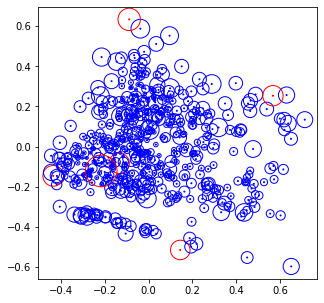

In [73]:
modelo_lof = LocalOutlierFactor(
    n_neighbors=N_VIZINHOS,
    contamination=FRACAO_OUTLIERS,
)

modelo_lof.fit(X_pca)
previsao = modelo_lof.fit_predict(X_pca)

fig, eixo = plt.subplots(figsize=(5, 5))

eixo.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    marker=".",
    s=4,
    color=CORES[(previsao + 1) // 2],
)

# plota os círculos!
X_lof = modelo_lof.negative_outlier_factor_
raios = (X_lof.max() - X_lof) / (X_lof.max() - X_lof.min())
eixo.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    s=1000 * raios,
    edgecolors=CORES[(previsao + 1) // 2],
    facecolors="none",
)

plt.show()

#### Isolation Forest

É um algoritmo de detecção de valores anômalos que utiliza uma floresta de árvores de decisão para realizar a sua detecção. As anomalias são detectadas usando o isolamento, observando a distância entre um ponto de dados e o restante dos dados. A floresta de isolamento divide o espaço de dados usando linhas ortogonais em relação à origem e atribui pontuações de anomalia mais altas a pontos de dados que precisam de poucas divisões para serem isolados. Para isolar um ponto de dados, o algoritmo gera recursivamente partições na amostra selecionando aleatoriamente um atributo e, em seguida, selecionando aleatoriamente um valor de divisão para o atributo, entre os valores mínimo e máximo permitidos para esse atributo.


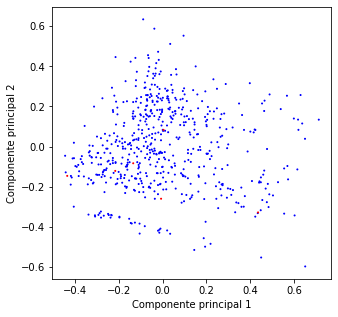

In [74]:
# Indica a fração de outlier que será detectada no conjunto de dados
FRACAO_OUTLIERS = 0.01

CORES = np.array(["red", "blue"])

modelo_if = IsolationForest(
    contamination=FRACAO_OUTLIERS,
    random_state=SEMENTE_ALEATORIA,
)

# Ajusta o modelo aos dados e realiza a previsão
modelo_if.fit(X_pca)
previsao = modelo_if.predict(X_pca)

fig, eixo = plt.subplots(figsize=(5, 5))

eixo.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    s=1,
    color=CORES[(previsao + 1) // 2],
)

eixo.set_xlabel("Componente principal 1")
eixo.set_ylabel("Componente principal 2")
plt.show()

In [75]:
# Os dados considerados anômalos pelo algoritmo são removidos

logic = previsao == 1
X_clean = X[logic]

print(X.shape)
print(X_clean.shape)

(588, 5)
(582, 5)


In [76]:
# fazer gráfico multidimensional multi dimensional plot